In [1]:
!pip install numpy torch torchvision matplotlib -q

In [2]:
import copy
from pathlib import Path

import matplotlib
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18

from cka import compute_cka
from viz import plot_cka_layer_trend, plot_cka_trend, save_figure

matplotlib.use('Agg')


In [3]:
SEED = 42
EPOCHS = 100
TRAIN_SAMPLES = 512
CKA_SAMPLES = 256
BATCH_SIZE = 64
NUM_WORKERS = 2

RESNET18_LAYERS = [
    'conv1',
    'layer1.0.conv1',
    'layer2.0.conv1',
    'layer3.0.conv1',
    'layer4.0.conv1',
    'fc',
]

In [4]:
def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def build_resnet18_cifar(num_classes: int = 10) -> nn.Module:
    model = resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def get_cifar10_subset(train: bool, size: int, seed: int) -> Subset:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ])
    dataset = CIFAR10(root='./data', train=train, download=True, transform=transform)
    generator = torch.Generator().manual_seed(seed)
    indices = torch.randperm(len(dataset), generator=generator)[:size].tolist()
    return Subset(dataset, indices)


In [5]:
set_seed(SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Using device:', device)

output_dir = Path('plots')
output_dir.mkdir(parents=True, exist_ok=True)

print('Preparing CIFAR-10 subsets...')
train_subset = get_cifar10_subset(train=True, size=TRAIN_SAMPLES, seed=SEED)
cka_subset = get_cifar10_subset(train=False, size=CKA_SAMPLES, seed=SEED + 1)

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
cka_loader = DataLoader(
    cka_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

model = build_resnet18_cifar()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

print('Capturing epoch-0 baseline...')
baseline_state = copy.deepcopy(model.state_dict())

epoch_states = [(0, baseline_state)]  # Store (epoch_num, state) tuples
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / max(1, len(train_loader))
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch}/{EPOCHS} - loss: {avg_loss:.4f}')
    if epoch % 10 == 0:
        epoch_states.append((epoch, copy.deepcopy(model.state_dict())))

print('Computing CKA per epoch...')
baseline_model = build_resnet18_cifar()
baseline_model.load_state_dict(baseline_state)

diag_by_epoch = []
last_cka_matrix = None
for epoch_num, state in epoch_states:
    epoch_model = build_resnet18_cifar()
    epoch_model.load_state_dict(state)

    cka_matrix = compute_cka(
        baseline_model,
        epoch_model,
        cka_loader,
        layers=RESNET18_LAYERS,
        model2_layers=RESNET18_LAYERS,
        device=device,
        progress=False,
    )[0]
    last_cka_matrix = cka_matrix
    diag = torch.diag(cka_matrix).detach().cpu().numpy()
    diag_by_epoch.append(diag)
    print(f'Epoch {epoch_num}: mean diag CKA = {diag.mean():.4f}')

epochs = [epoch_num for epoch_num, _ in epoch_states]
layer_trends = np.stack(diag_by_epoch, axis=0).T

fig, ax = plot_cka_trend(
    layer_trends,
    x_values=epochs,
    labels=RESNET18_LAYERS,
    markers=['o'],
    xlabel='Epoch',
    ylabel='CKA Similarity vs Epoch 0',
    title='ResNet-18 CKA Trends Across Epochs (CIFAR-10)',
    legend=True,
)
for line in ax.get_lines():
    line.set_markersize(3)
ax.set_xticks(list(range(0, EPOCHS + 1, 10)))
ax.set_xlim(0, EPOCHS)
save_figure(fig, str(output_dir / 'resnet18_cifar10_cka_epoch_trends.png'))

if last_cka_matrix is not None:
    fig, ax = plot_cka_layer_trend(
        last_cka_matrix,
        layers=RESNET18_LAYERS,
        title=f'ResNet-18 CKA Diagonal (Epoch {EPOCHS})',
    )
    save_figure(fig, str(output_dir / 'resnet18_cifar10_cka_layer_trend.png'))

print('Saved to:', output_dir)

Using device: cuda
Preparing CIFAR-10 subsets...


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Capturing epoch-0 baseline...
Epoch 1/100 - loss: 2.6759
Epoch 10/100 - loss: 0.8516
Epoch 20/100 - loss: 0.2673
Epoch 30/100 - loss: 0.0014
Epoch 40/100 - loss: 0.0003
Epoch 50/100 - loss: 0.0001
Epoch 60/100 - loss: 0.0001
Epoch 70/100 - loss: 0.0001
Epoch 80/100 - loss: 0.0161
Epoch 90/100 - loss: 0.0126
Epoch 100/100 - loss: 0.0003
Computing CKA per epoch...
Epoch 0: mean diag CKA = 1.0000
Epoch 10: mean diag CKA = 0.4865
Epoch 20: mean diag CKA = 0.5353
Epoch 30: mean diag CKA = 0.6172
Epoch 40: mean diag CKA = 0.6176
Epoch 50: mean diag CKA = 0.6175
Epoch 60: mean diag CKA = 0.5969
Epoch 70: mean diag CKA = 0.6022
Epoch 80: mean diag CKA = 0.6327
Epoch 90: mean diag CKA = 0.5915
Epoch 100: mean diag CKA = 0.6083
Saved to: plots


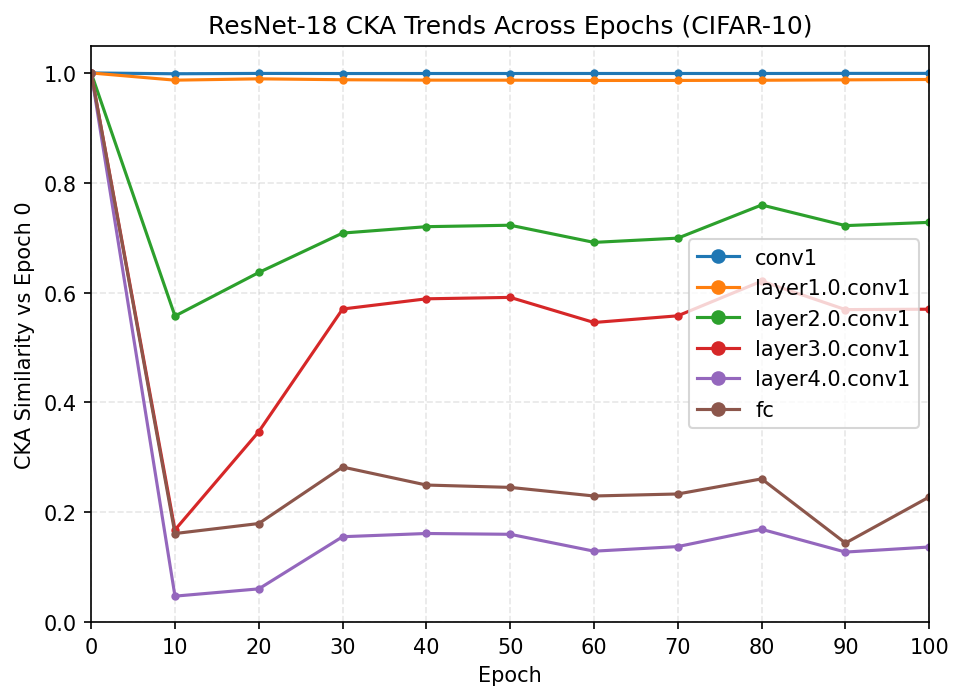

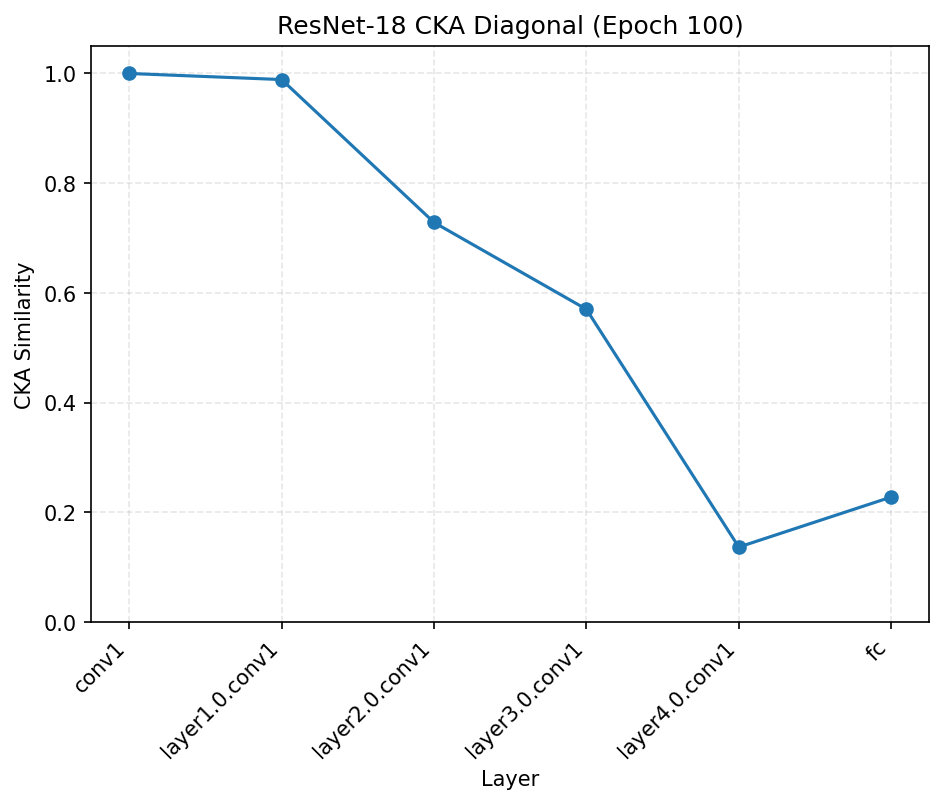

In [6]:
from IPython.display import Image, display

display(Image(filename=str(output_dir / 'resnet18_cifar10_cka_epoch_trends.png')))
display(Image(filename=str(output_dir / 'resnet18_cifar10_cka_layer_trend.png')))
